In [1]:
import torch
from torch import optim
from tqdm import tqdm
# Imports for this repository
from simplex_generator import simplex_params
from md_gan_modules import LambdaNetwork, Discriminator, Generator
from gmm_data_generator import load_db
from numpy_dataset import NumpyDataset
from md_gan_training import MDGANTraining,gaussian_likelihood_sum

# Fix Parameters

In [2]:
PARAMS = {'batch_size': 512,
          'zdim': 2,
          'gamma':0.5,
          'beta1':0.5,
          'beta2':0.999,
          'n_lr_steps':3,
          'lambda_training_iterations':10001,
          'epochs':501, #1000
          'eta_lambda': 0.01,
          'e_dim': 9,
          'lr_d': 1e-3,
          'lr_g': 1e-3,
          'epsilon': 1e-8,  # for avoiding numerical instabilities
          'samp_num_gen': 2500}

In [3]:
working_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simplex = simplex_params(PARAMS['e_dim'], working_device) # Create Simplex
print("Current Working Device is set to:" + str(working_device))

Current Working Device is set to:cuda


# Search for $\lambda$

In [64]:
lambda_net = LambdaNetwork(PARAMS['e_dim']).to(working_device)
lambda_training_data = torch.tensor([1.0], device=working_device, dtype=torch.float32, requires_grad=False)
optimizer_lambda = optim.Adam(lambda_net.parameters(), lr=PARAMS['eta_lambda'])

for i in tqdm(range(PARAMS['lambda_training_iterations'])):
    optimizer_lambda.zero_grad()
    e = lambda_net(lambda_training_data)
    lambda_lk = gaussian_likelihood_sum(e, simplex)
    lambda_loss = -torch.log(PARAMS['epsilon'] + lambda_lk).mean()
    if i % 2500 == 0 and i > 0:
        print("Lambda Loss:" + str(lambda_loss.item()))
        for group in optimizer_lambda.param_groups:
            group['lr'] = group['lr'] * PARAMS['gamma']
    lambda_loss.backward()
    optimizer_lambda.step()
e = lambda_net(lambda_training_data)
lambda_value = gaussian_likelihood_sum(e, simplex).sum().item()
print(lambda_value)

 26%|██▌       | 2584/10001 [00:04<00:11, 647.06it/s]

Lambda Loss:-3.538743019104004


 50%|█████     | 5039/10001 [00:08<00:13, 356.98it/s]

Lambda Loss:-3.538743019104004


 76%|███████▌  | 7561/10001 [00:13<00:04, 609.66it/s]

Lambda Loss:-3.538743019104004


100%|██████████| 10001/10001 [00:17<00:00, 579.79it/s]

Lambda Loss:-3.538743019104004
34.423622131347656


In [4]:
lambda_value = 34.43 # I put it manually here so that I don't have to run the last cell again and again if I didn't change the parameters

# Train Generator and Discriminator

In [5]:
net_g = Generator(PARAMS['zdim']).to(working_device) # Init generator function
# net_g.load_state_dict(torch.load("generator_9.pt")) # A enlever si on veut reprendre à 0

net_d = Discriminator(PARAMS['e_dim']).to(working_device) # Init discriminator function
optimizer_g = optim.Adam(net_g.parameters(), lr=PARAMS['lr_g'], betas=(PARAMS['beta1'], PARAMS['beta2']))
optimizer_d = optim.Adam(net_d.parameters(), lr=PARAMS['lr_d'], betas=(PARAMS['beta1'], PARAMS['beta2']))

epoch_step_size=PARAMS['epochs']/(PARAMS['n_lr_steps']+1) # calculate learning rate decay step size
lr_steps=[int((i+1)*epoch_step_size) for i in range(PARAMS['n_lr_steps'])] 
print("Learning rate steps:",lr_steps)
lr_g = optim.lr_scheduler.MultiStepLR(optimizer_g, lr_steps, gamma=PARAMS['gamma'])
lr_d = optim.lr_scheduler.MultiStepLR(optimizer_d, lr_steps, gamma=PARAMS['gamma'])

training_data = load_db(min_point=-3, max_point=3) 
train_dataset = NumpyDataset(training_data)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=PARAMS['batch_size'],
                                           shuffle=True)

md_gan_training=MDGANTraining(net_d, net_g, optimizer_d,optimizer_g,PARAMS['batch_size'], PARAMS['zdim'], simplex,
                     PARAMS['epsilon'],
                     lambda_value,
                     working_device)


Learning rate steps: [125, 250, 375]
mu_vector.shape : (9, 2)
variance.shape : (9,)


In [6]:
from matplotlib import pyplot as plt

epoch_samples = {}

# Start Training Loop
print(f"Start training...")
pbar = tqdm(range(PARAMS['epochs']))
for epoch in pbar:
    for d in train_loader:
        d = d.to(working_device)
        d_loss = md_gan_training.update_discriminator(d)
        g_loss = md_gan_training.update_generator()
        pbar.set_postfix(d_loss=d_loss, g_loss=g_loss)

    lr_g.step(epoch)  # update Generator learning rate
    lr_d.step(epoch)  # update Discriminator learning rate
    
    if epoch in [0, 250, 500]:
        g_samples = net_g(torch.randn(PARAMS['batch_size'], PARAMS['zdim']).to(working_device))
        g_samples = g_samples.cpu().detach().numpy()
        epoch_samples[epoch] = g_samples

Start training...


  0%|          | 0/501 [00:00<?, ?it/s, d_loss=-5.75, g_loss=2.88] /home/noambsf/miniconda3/envs/datalab/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 501/501 [02:02<00:00,  4.08it/s, d_loss=-5.73, g_loss=2.85]


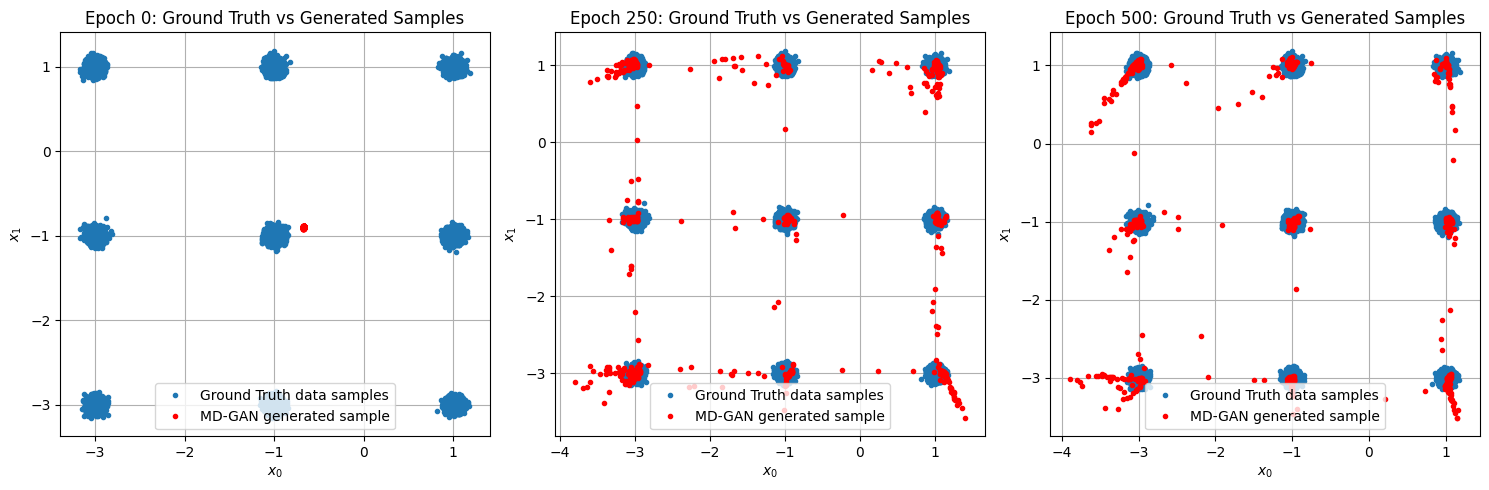

In [7]:
# Create subplots for the specified epochs
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, epoch in enumerate([0, 250, 500]):
    axes[i].plot(training_data[:, 0], training_data[:, 1], 'o', label='Ground Truth data samples', markersize=3)
    axes[i].plot(epoch_samples[epoch][:, 0], epoch_samples[epoch][:, 1], 'o', label='MD-GAN generated sample', color='red', markersize=3)
    axes[i].set_title(f"Epoch {epoch}: Ground Truth vs Generated Samples")
    axes[i].legend()
    # axes[i].set_xlim([-8, 5])  # Ajuster les limites de l'axe x
    # axes[i].set_ylim([-8, 5])  # Ajuster les limites de l'axe y
    axes[i].set_xlabel(r'$x_0$')
    axes[i].set_ylabel(r'$x_1$')
    axes[i].grid()

plt.tight_layout()
plt.show()


# Plot Samples from the Generator

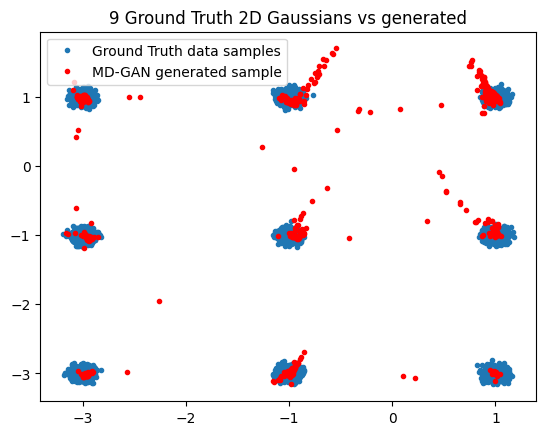

In [ ]:
from matplotlib import pyplot as plt

# With training

g_samples = net_g(torch.randn(PARAMS['batch_size'], PARAMS['zdim']).to(working_device))
g_samples = g_samples.cpu().detach().numpy()

plt.plot(training_data[:, 0], training_data[:, 1], 'o',label='Ground Truth data samples', markersize='3')
plt.plot(g_samples[:, 0], g_samples[:, 1], 'o',label='MD-GAN generated sample', color='red', markersize=3)
plt.title("9 Ground Truth 2D Gaussians vs generated")
plt.legend()
# plt.grid()
# plt.xlabel(r'$x_o$')
# plt.ylabel(r'$x_1$')
plt.show() 

# Save Generator

In [27]:
torch.save(net_g.state_dict(), 'generator_9.pt')


In [ ]:
# import torch
# import os
# import torchvision
# import torch.nn.functional as F

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# d = 100  # dimension of latent space
# K = 11  # size of the output of discrimnator


# def D_train(x, y, G, D, GM, D_optimizer, criterion):
#     # =======================Train the discriminator=======================#
#     D.zero_grad()

#     # train discriminator on real samples
#     x_real, y_real = x, y
#     x_real, y_real = x_real.to(DEVICE), y_real.to(DEVICE)

#     D_output_real = D(x_real)
#     D_real_loss = criterion(D_output_real, y_real)

#     k_values = torch.randint(0, K, (x.shape[0],), device=DEVICE)
#     y = F.one_hot(k_values, num_classes=K).to(DEVICE).float()
#     z = torch.randn(x.shape[0], d, device=DEVICE, dtype=torch.float32)

#     # the vector of latent space sampled from the Gaussian Mixture
#     z_tilde = GM(y, z)

#     # Generate fake sample x_fake
#     x_fake = G(z_tilde)

#     D_output_fake = D(x_fake)
#     target_fake = torch.full((x.shape[0],), 10, dtype=torch.long).to(DEVICE)
#     D_fake_loss = criterion(D_output_fake, target_fake)

#     # gradient backpropagation and optimization of D's parameters
#     D_loss = D_real_loss + D_fake_loss
#     D_loss.backward()
#     D_optimizer.step()

#     return D_loss.data.item()


# def G_train(x, G, D, GM, G_optimizer, GM_optimizer, criterion):
#     # =======================Train the generator=======================#
#     G.zero_grad()
#     GM.zero_grad()

#     # representing one of the K Gaussian distributions
#     k_values = torch.randint(0, K, (x.shape[0],), device=DEVICE)
#     y = F.one_hot(k_values, num_classes=K).to(DEVICE).float()
#     z = torch.randn(x.shape[0], d, device=DEVICE, dtype=torch.float32)

#     # the vector of latent space sampled from the Gaussian Mixture
#     z_tilde = GM(y, z)
#     G_output = G(z_tilde)
#     D_output = D(G_output)

#     G_loss = criterion(D_output, k_values)

#     # gradient backpropagation and optimization of G and GM's parameters
#     G_loss.backward()
#     G_optimizer.step()
#     # GM is an extension of two layers of the generator
#     GM_optimizer.step()

#     return G_loss.data.item()


# def save_models(G, D, GM, folder):
#     torch.save(G.state_dict(), os.path.join(folder, "G.pth"))
#     torch.save(D.state_dict(), os.path.join(folder, "D.pth"))
#     torch.save(GM.state_dict(), os.path.join(folder, "GM.pth"))


# def load_model(G, GM, folder, Discriminator=None):
#     ckpt_G = torch.load(os.path.join(folder, "G.pth"))
#     ckpt_GM = torch.load(os.path.join(folder, "GM.pth"))
#     G.load_state_dict({k.replace("module.", ""): v for k, v in ckpt_G.items()})
#     GM.load_state_dict({k.replace("module.", ""): v for k, v in ckpt_GM.items()})
#     if not Discriminator == None:
#         ckpt_D = torch.load(os.path.join(folder, "D.pth"))
#         Discriminator.load_state_dict(
#             {k.replace("module.", ""): v for k, v in ckpt_D.items()}
#         )


# # Updated MNIST to PNG function
# def save_mnist_as_png(output_folder, train=True):
#     os.makedirs(output_folder, exist_ok=True)
#     dataset = torchvision.datasets.MNIST(
#         root="./data",
#         train=train,
#         download=True,
#         transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
#     )

#     for idx, (img, label) in enumerate(dataset):
#         img = img.squeeze(0)
#         pil_img = torchvision.transforms.ToPILImage()(img)
#         pil_img.save(f"{output_folder}/image_{idx}.png")

#     print(f"Saved {len(dataset)} images to '{output_folder}'.")


# def generate_fake_samples(generator, gm, num_samples, batch_size=2048):
#     """Function to generate fake samples using the generator"""
#     n_samples = 0
#     with torch.no_grad():
#         while n_samples < num_samples:
#             z = torch.randn(batch_size, 100).to(DEVICE)
#             k_values = torch.randint(0, 10, (batch_size,))
#             y = torch.eye(K)[k_values].to(DEVICE)
#             N = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
#             z = N.sample((batch_size,)).to(DEVICE).to(torch.float32)
#             z_tilde = gm(y, z)
#             x = generator(z_tilde)
#             x = x.reshape(batch_size, 28, 28)
#             for k in range(x.shape[0]):
#                 if n_samples < num_samples:
#                     torchvision.utils.save_image(
#                         x[k : k + 1],
#                         os.path.join("samples_train", f"{n_samples}.png"),
#                     )
#                     n_samples += 1


# if __name__ == "__main__":
#     save_mnist_as_png("real_samples")